# Introduction


## Context
A startup that sells software would like to know whether its multiple outreach efforts were successful in attracting new customers or boosting consumption among existing customers. They would also like to distinguish the effects of several incentives on different kinds of customers. In other words, they would like to learn the heterogeneous treatment effect of each investment on customers' software usage.

In an ideal world, the startup would run several randomized experiments where each customer would receive a random assortment of investments. However, this can be logistically prohibitive or strategically unsound: the startup might not have the resources to design such experiments or they might not want to risk losing out on big opportunities due to lack of incentives.

## Content
The data* contains ~2,000 customers and is comprised of:

Customer features: details about the industry, size, revenue, and technology profile of each customer.<br>
Interventions: information about which incentive was given to a customer.<br>
Outcome: the amount of product the customer bought in the year after the incentives were given.<br>

# Solution Planning

## IOT (Input, Output, Tasks)

### Inputs
- Data from customers and interventions (incentives given)

### Outputs
- Presentation with the results of the campaing, bringing the isolate effect of each incentive on the consumption of the clients

### Tasks
1. Get the data
    (In this case we have the .csv file, but this step could involve writting a query to get the data from a data warehouse)
2. Do an exploratory analysis to get acquainted with the features
3. Apply Causal Inference techniques
4. Make a presentation with the results

# Code

## 0.0 Imports

In [20]:
import pandas as pd
import numpy as np 

import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image

from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *


from scipy.stats import ttest_ind, shapiro, mannwhitneyu

from causalml.match import create_table_one

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression


### 0.1 Data

In [2]:
data_raw = pd.read_csv('../data/multi_attribution_sample.csv')

In [3]:
data_raw.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


### 0.2 Auxiliar functions

In [4]:
def jupyter_settings():
    %matplotlib inline
   # %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 100
    pd.options.display.max_rows = 100
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()


pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1.0 Descriptive analysis

In [5]:
data_description = data_raw.copy()

### 1.1 Renaming columns (to snake case)

In [6]:
new_columns = [i.lower().replace(' ', '_') for i in data_description.columns]
data_description.columns = new_columns
    

In [7]:
data_description.head()

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.363
1,0,0,1,1,20842,107,70,159038,0,1,14981.436
2,0,0,0,1,82171,10,7,264935,1,1,32917.139
3,0,0,0,0,30288,40,39,77522,1,1,14773.769
4,0,0,1,0,25930,37,43,91446,1,1,17098.698


## 2.0 Causal Inference

tech_support -> revenue <br>
tech_support <- size -> revenue <br>
tech_support <- size -> discount -> revenue <br>

In [19]:
_, p = shapiro(data_description['revenue'])

alpha = 0.05  # significance level
if p > alpha:
    print('data follows a normal distribution (H0)')
else:
    print('data dont folow a normal distribution (reject H0) so we must use Wilcoxon-Mann-Whitne to test the mean differences ')

print('Valor p: %.5f' % p)

data dont folow a normal distribution (reject H0) so we must use Wilcoxon-Mann-Whitne to test the mean differences 
Valor p: 0.00000


In [102]:
data_control = data_description.loc[data_description['tech_support'] == 0]
data_treatment = data_description.loc[data_description['tech_support'] == 1]

print(data_control['revenue'].mean(), data_treatment['revenue'].mean())
print((np.mean(data_treatment['revenue']) - np.mean(data_control['revenue'])) / np.mean(data_control['revenue']))
# compare samples
_, p = mannwhitneyu(data_control['revenue'], data_treatment['revenue'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9302.989442380383 21420.142482802188
1.302500998788767
p=0.000
different distributions/different group mean (reject H0)


In [138]:
data_control = data_description.loc[data_description['discount'] == 0]
data_treatment = data_description.loc[data_description['discount'] == 1]

print(data_control['revenue'].mean(), data_treatment['revenue'].mean())
print((np.mean(data_treatment['revenue']) - np.mean(data_control['revenue'])) / np.mean(data_control['revenue']))

# compare samples
_, p = mannwhitneyu(data_control['revenue'], data_treatment['revenue'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

10605.72582761522 19992.976746513028
0.8851115964600231
p=0.000
different distributions/different group mean (reject H0)


In [12]:
data_description.columns

Index(['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'tech_support', 'discount',
       'revenue'],
      dtype='object')

In [24]:
X = ['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'discount']
table1 = create_table_one(data_description, 'tech_support', X)
table1

,Control,Treatment,SMD
Variable,,,
n,994,1006,
commercial_flag,0.72 (0.45),0.67 (0.47),-0.105
discount,0.48 (0.50),0.54 (0.50),0.122
employee_count,59.63 (53.95),62.58 (52.94),0.055
global_flag,0.19 (0.39),0.21 (0.41),0.059
it_spend,21066.49 (20431.96),35392.95 (32680.07),0.526
major_flag,0.18 (0.38),0.21 (0.41),0.095
pc_count,56.13 (53.09),58.55 (52.63),0.046
size,83191.32 (71555.11),142769.45 (116019.33),0.618


In [25]:
X = ['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'tech_support']
table1 = create_table_one(data_description, 'discount', X)
table1

,Control,Treatment,SMD
Variable,,,
n,979,1021,
commercial_flag,0.69 (0.46),0.69 (0.46),-0.011
employee_count,60.29 (53.27),61.91 (53.64),0.030
global_flag,0.20 (0.40),0.20 (0.40),-0.001
it_spend,22915.61 (24072.31),33409.43 (30817.72),0.380
major_flag,0.21 (0.41),0.18 (0.39),-0.071
pc_count,56.11 (51.51),58.53 (54.13),0.046
size,88892.64 (78095.11),136427.37 (114158.66),0.486
smc_flag,0.51 (0.50),0.50 (0.50),-0.016


It should not be assumed that these differences in means represent the average causal effect. This is primarily due to the fact that the treatments were not randomly assigned, as in an A/B test. Through our causal discovery analysis, we have determined that size is a critical factor in determining which clients should receive treatment, and that size directly impacts revenue. Therefore, if we want to accurately measure the causal effect of our treatments, we must utilize observational or quasi-experimental techniques.

### 2.2 First method to infer causal effects: Propensity Score Matching

In [26]:
data_matching = data_description.copy()

#### 2.2.1 Effect of Tech Support

#### 1st: Calculate Propensity Score for all units given each treatment

To accomplish this task, I plan to conduct a Logistic Regression analysis, utilizing the main variables in the DAG, namely tech_support, size, revenue, and discount.

In [28]:
data_matching.columns

Index(['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'tech_support', 'discount',
       'revenue'],
      dtype='object')

In [29]:
X = data_matching[['discount', 'size', 'it_spend']]
y = data_matching['tech_support']

In [32]:
lr = LogisticRegression()
lr.fit(X,y)

LogisticRegression()

In [35]:
coeficients = pd.DataFrame({'column': X.columns.to_numpy(), 'coeficient':lr.coef_.ravel()})
coeficients

,column,coeficient
0,discount,-0.000
1,size,0.000
2,it_spend,-0.000


In [36]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

print('the binary prediction is:', pred_binary[0])
print('the corresponding probabilities are:', pred_prob[0])

the binary prediction is: 1
the corresponding probabilities are: [0.39981904 0.60018096]


In [39]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
data_matching['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching if needed
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

data_matching['ps_logit'] = data_matching.ps.apply(lambda x: logit(x))

data_matching.head()

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue,ps,ps_logit
0,1,0,1,0,45537,26,26,152205,0,1,17688.363,0.600,0.406
1,0,0,1,1,20842,107,70,159038,0,1,14981.436,0.625,0.510
2,0,0,0,1,82171,10,7,264935,1,1,32917.139,0.668,0.698
3,0,0,0,0,30288,40,39,77522,1,1,14773.769,0.546,0.184
4,0,0,1,0,25930,37,43,91446,1,1,17098.698,0.562,0.249


<Axes: xlabel='ps_logit', ylabel='Count'>

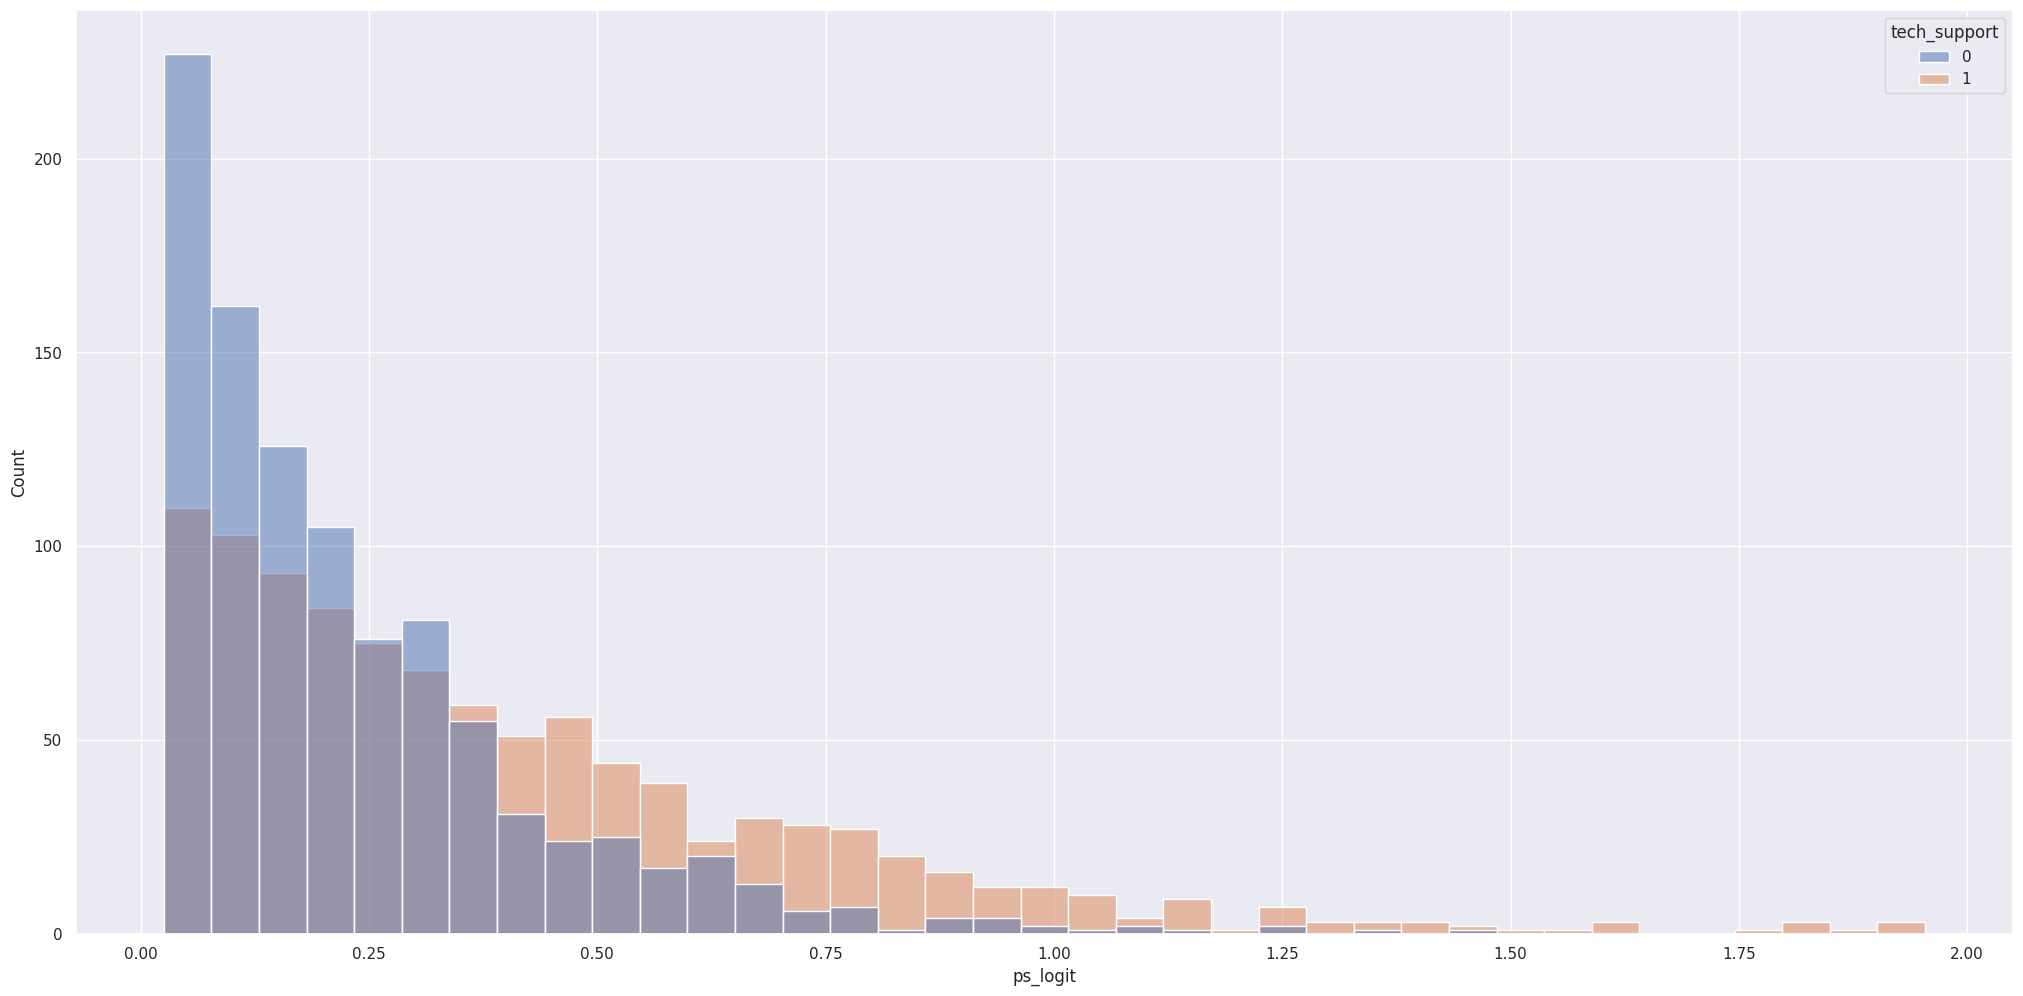

In [43]:
sns.histplot(data=data_matching, x='ps_logit', hue='tech_support')

In [86]:



caliper = np.std(data_matching.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 5

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = data_matching[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0163


NearestNeighbors(radius=0.01632885676220617)

In [87]:
distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

(2000, 5)
[0.00000000e+00 2.97316720e-05 6.53152797e-05 1.31436817e-04
 2.82348141e-04]
[   0 1785  844  236  166]


In [88]:
matched_control = []  # keep track of the matched observations in control

for current_index, row in data_matching.iterrows():  
    if row.tech_support == 0:  # the current row is in the control group
        data_matching.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (data_matching.loc[idx].tech_support == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    data_matching.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [89]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(data_matching[data_matching.tech_support==1]))
print('total matched observations in control:', len(matched_control))

total observations in treatment: 1006
total matched observations in control: 596


In [90]:
data_matching.isna().sum()

global_flag           0
major_flag            0
smc_flag              0
commercial_flag       0
it_spend              0
employee_count        0
pc_count              0
size                  0
tech_support          0
discount              0
revenue               0
ps                    0
ps_logit              0
matched            1199
dtype: int64

In [91]:
# control have no match
treatment_matched = data_matching.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = data_matching.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
data_matched = pd.concat([treatment_matched, control_matched])

data_matched.tech_support.value_counts()

1    801
0    801
Name: tech_support, dtype: int64

In [104]:
X = ['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'discount']
table1 = create_table_one(data_matched, 'tech_support', X)
table1

,Control,Treatment,SMD
Variable,,,
n,801,801,
commercial_flag,0.72 (0.45),0.67 (0.47),-0.103
discount,0.51 (0.50),0.49 (0.50),-0.037
employee_count,59.37 (55.30),62.31 (52.41),0.055
global_flag,0.18 (0.39),0.21 (0.41),0.069
it_spend,27518.15 (24972.81),27748.58 (26007.31),0.009
major_flag,0.18 (0.39),0.23 (0.42),0.102
pc_count,56.25 (55.17),57.98 (51.57),0.032
size,109133.90 (86281.10),109347.26 (87272.49),0.003


In [94]:
# matched control and treatment
data_matched_control = data_matched[data_matched.tech_support==0]
data_matched_treatment = data_matched[data_matched.tech_support==1]

In [103]:
print(data_matched_control['revenue'].mean(), data_matched_treatment['revenue'].mean())
print((np.mean(data_matched_treatment['revenue']) - np.mean(data_matched_control['revenue'])) / np.mean(data_matched_control['revenue']))

# compare samples
_, p = mannwhitneyu(data_matched_control['revenue'], data_matched_treatment['revenue'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

11119.802843439074 18319.996517328338
0.6475109114131042
p=0.000
different distributions/different group mean (reject H0)


#### 2.2.2. Effect of discount (using PSMPy)

In [116]:
psm = PsmPy(data_matching[['tech_support', 'discount', 'revenue', 'size', 'it_spend']].reset_index(), treatment='discount', indx='index', exclude=['revenue'])

In [117]:
psm.logistic_ps(balance = True)

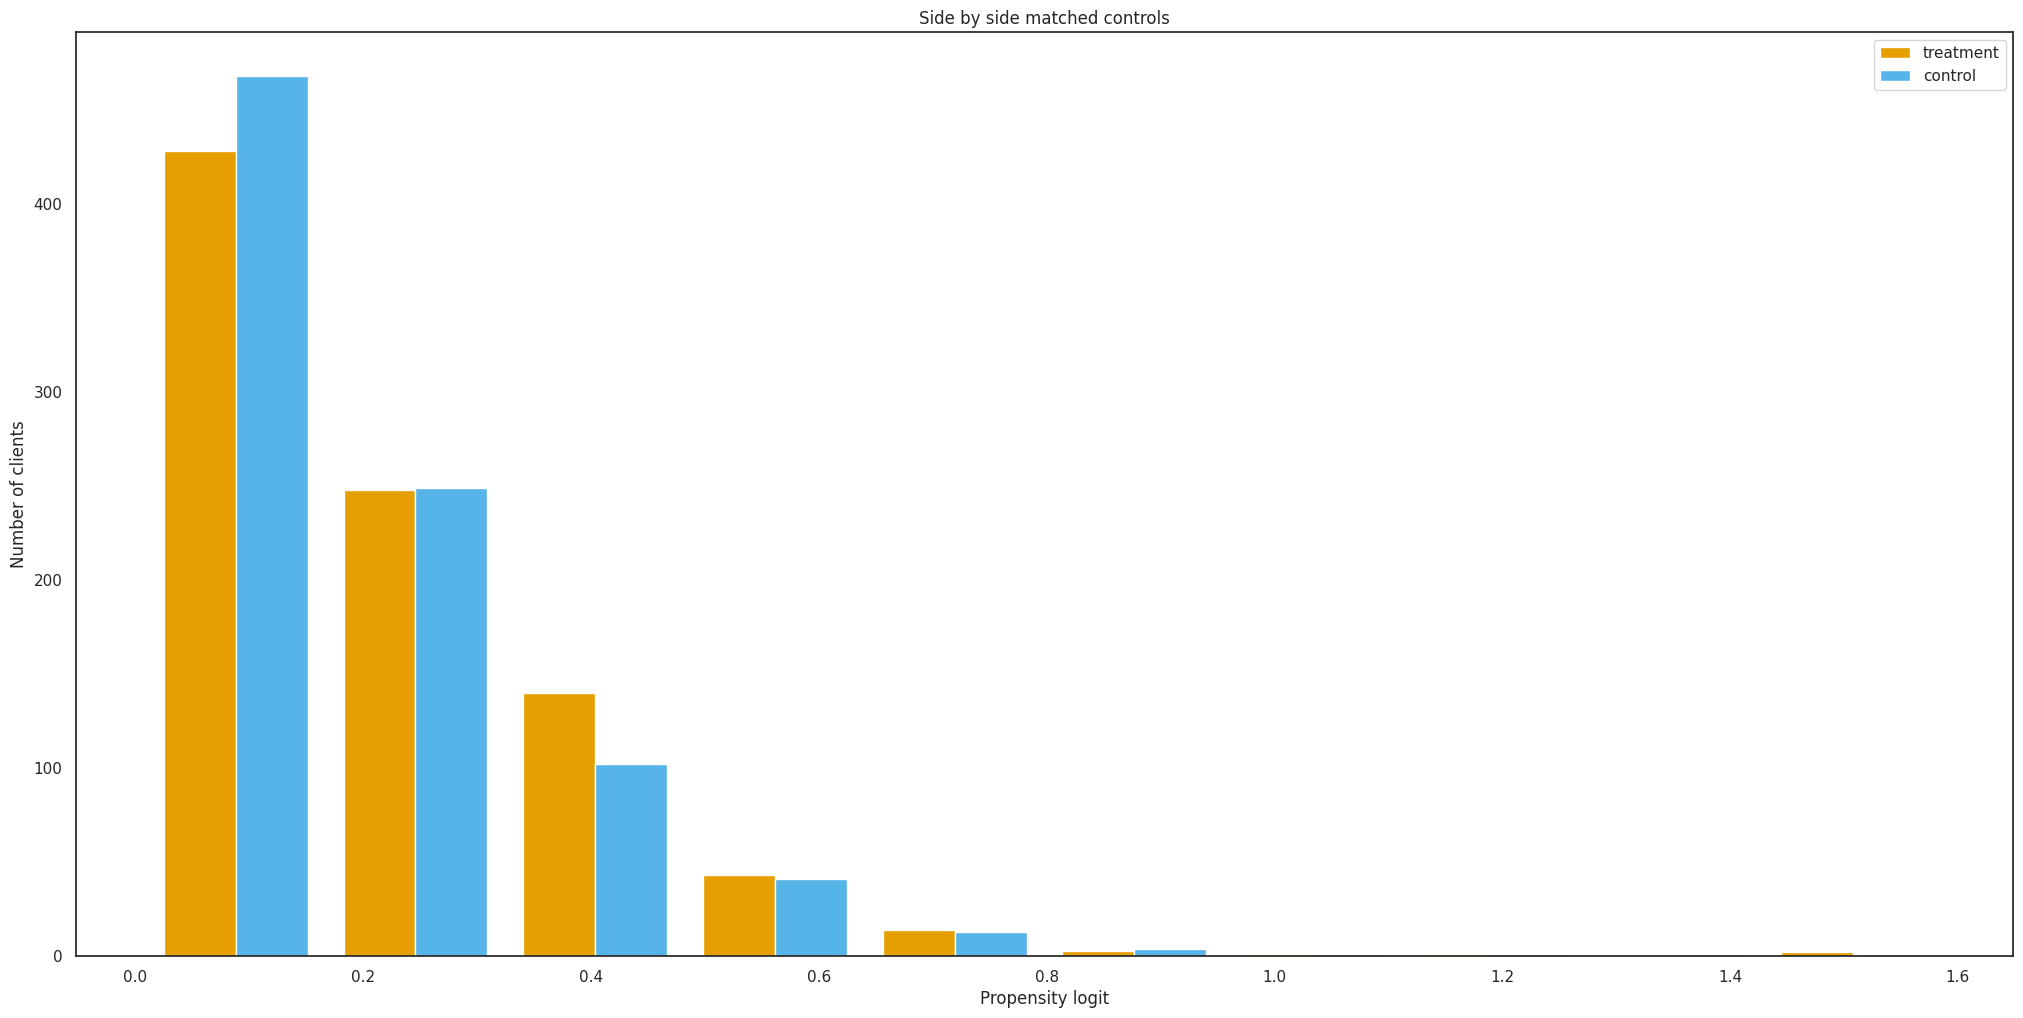

In [140]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of clients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], colors=['#E69F00', '#56B4E9'] ,save=False)

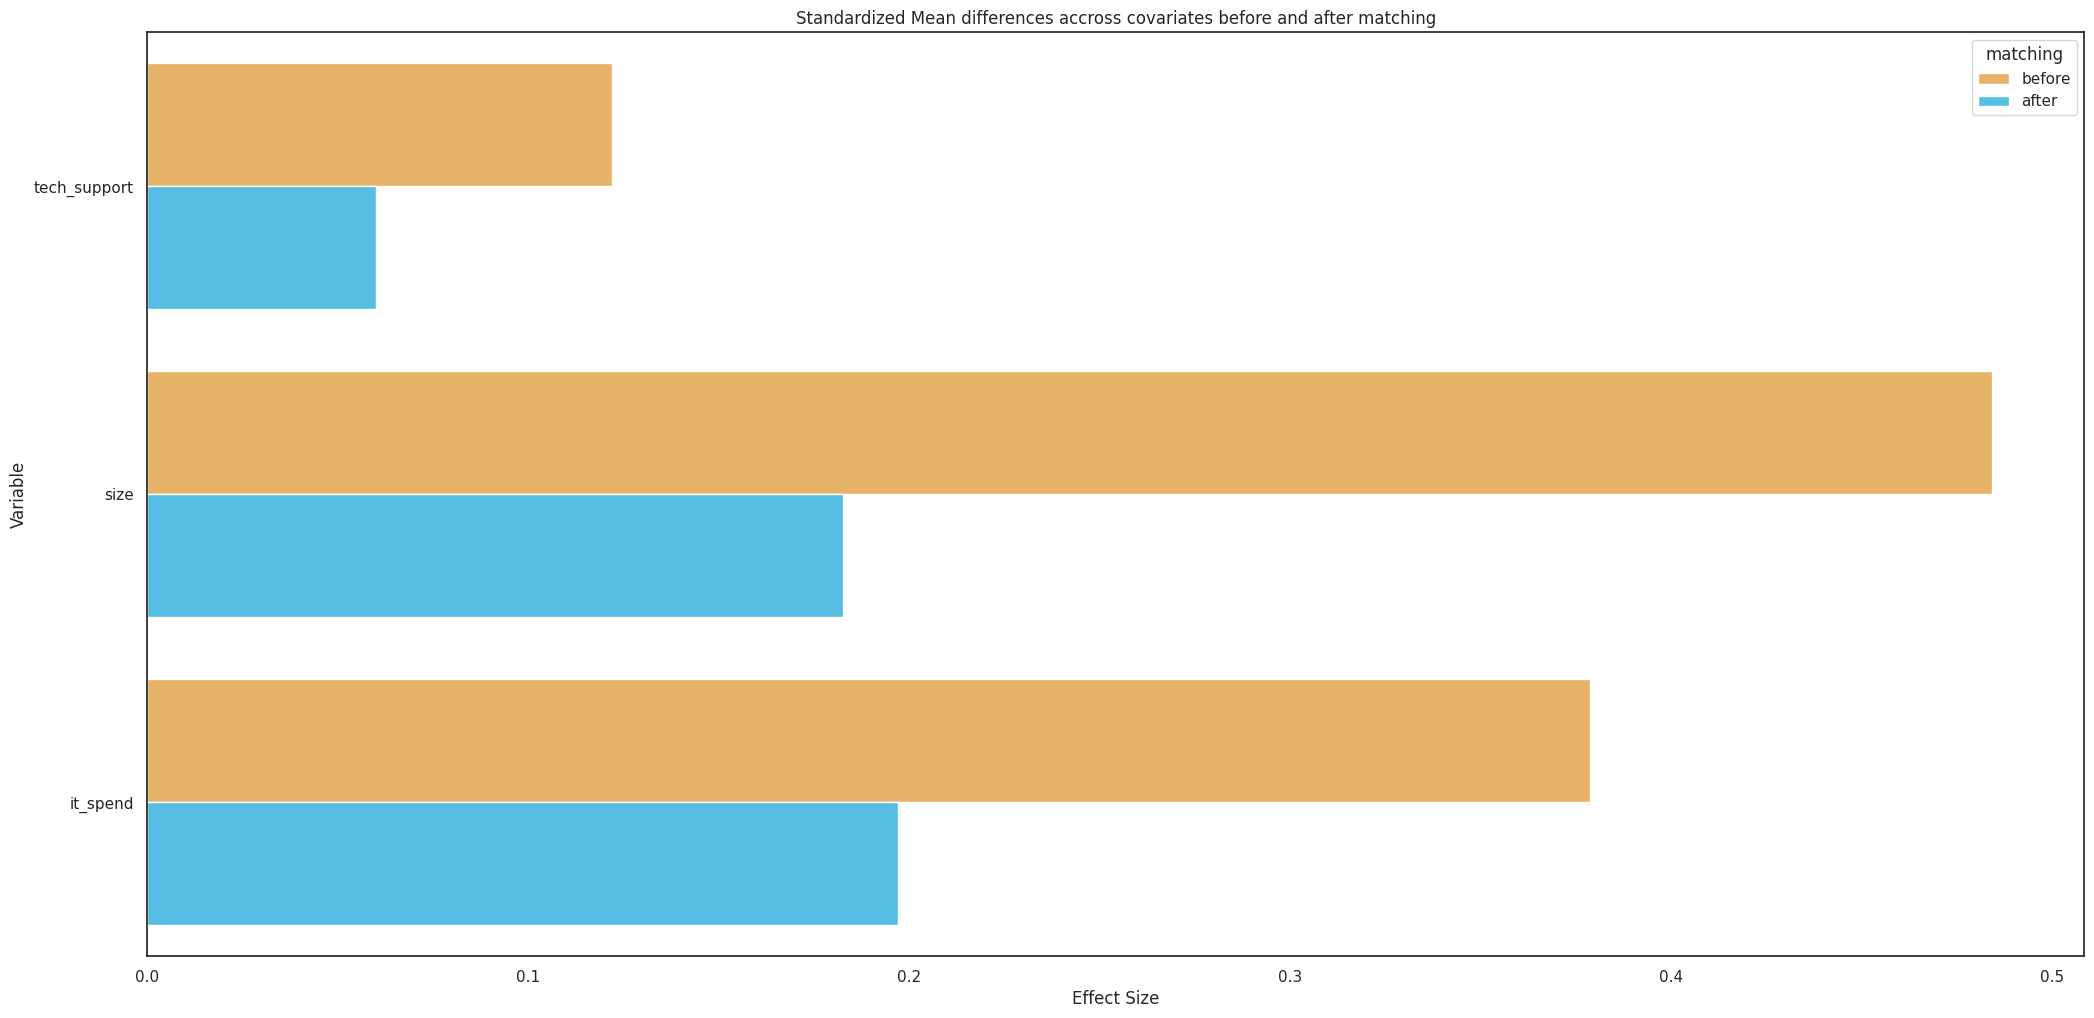

In [120]:
psm.effect_size_plot(save=False)

In [139]:
X = ['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'tech_support']
table1 = create_table_one(data_matched, 'discount', X)
table1

,Control,Treatment,SMD
Variable,,,
n,881,881,
commercial_flag,0.69 (0.46),0.68 (0.46),-0.022
employee_count,59.65 (52.27),61.48 (52.89),0.035
global_flag,0.21 (0.41),0.20 (0.40),-0.028
it_spend,23840.36 (24736.96),29021.01 (27582.42),0.198
major_flag,0.21 (0.41),0.18 (0.39),-0.069
pc_count,55.39 (50.21),57.94 (52.83),0.049
size,93470.25 (80075.38),108677.76 (85841.06),0.183
smc_flag,0.51 (0.50),0.50 (0.50),-0.011


In [133]:
ids = psm.matched_ids['index'].to_list() + psm.matched_ids['matched_ID'].astype('int64').to_list()

In [129]:
psm.df_matched

,index,tech_support,size,it_spend,propensity_score,propensity_logit,discount,matched_ID
0,56,1,60369,17049,0.540,0.158,0,846.000
1,77,0,12868,2867,0.508,0.032,0,584.000
2,152,0,27353,9867,0.519,0.076,0,1261.000
3,155,1,21975,7671,0.515,0.060,0,756.000
4,175,1,44931,13657,0.530,0.120,0,1018.000
...,...,...,...,...,...,...,...,...
1756,1114,1,147592,19511,0.617,0.476,1,NaN
1757,1145,1,146996,19168,0.617,0.477,1,NaN
1758,455,1,148376,19215,0.618,0.482,1,NaN
1759,1579,1,257270,72987,0.618,0.483,1,NaN


In [135]:
data_matched = data_matching.iloc[ids].drop(columns=['ps', 'ps_logit', 'matched'])

In [136]:
# matched control and treatment
data_matched_control = data_matched[data_matched.discount==0]
data_matched_treatment = data_matched[data_matched.discount==1]

In [137]:
print(data_matched_control['revenue'].mean(), data_matched_treatment['revenue'].mean())
print((np.mean(data_matched_treatment['revenue']) - np.mean(data_matched_control['revenue'])) / np.mean(data_matched_control['revenue']))

# compare samples
_, p = mannwhitneyu(data_matched_control['revenue'], data_matched_treatment['revenue'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

10778.557082356525 17111.696761541203
0.5875684129883606
p=0.000
different distributions/different group mean (reject H0)


Here, we employed two different methods to examine the causal impact of each treatment. By comparing the initial (naive) results to the refined approach, we discovered that the direct effect of each treatment on revenue is comparatively smaller. In the case of tech support, the average treatment effect was just under half of the original value, which is nearly identical to the effect of the discount. Had we relied solely on the first method of comparing mean differences, we may have incorrectly assumed that tech support was significantly more effective than the discount. However, a more thorough inferential analysis revealed that both treatments yielded comparable results, with each resulting in approximately a 60% increase in revenue.